**Course website**: http://lagex.github.io/geofisica2

**Note**: This notebook is part of the course "Geofísica 2" of Geology program of the 
[Universidade do Estado do Rio de Janeiro](http://www.uerj.br/). 
All content can be freely used and adapted under the terms of the 
[Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).

![Creative Commons License](https://i.creativecommons.org/l/by/4.0/88x31.png)

Esse documento que você está usando é um [IPython notebook](http://ipython.org/notebook.html). É um documento interativo que mistura texto (como esse), código (como abaixo), e o resultado de executar o código (que pode ser números, texto, figuras, videos, etc).

# Prática 5 - Sísmica de refração

Nessa prática vamos simular uma aquisição de sísmica de refração. A aquisição será feita para determinar a espessura de uma camada e as velocidades da onda P nessa camada e no meio abaixo. Nesse caso, a camada é a crosta e o meio abaixo é o manto, ou seja, estamos buscando a profundidade da Moho. Em seguida, utilizaremos outro modelo com duas camadas: uma bacia sedimentar e a crosta abaixo dela.

Utilizaremos as simulações de ondas da biblioteca [Fatiando a Terra](http://www.fatiando.org). Essas simulações utilizam o [método de diferenças finitas](http://en.wikipedia.org/wiki/Finite_difference_method) para calcular soluções da equação da onda.

As tarefas abaixo acompanham as questões que vocês devem responder. Usem as simulações abaixo para te ajudar a responder as perguntas.

## Preparação

Rode a célula abaixo para carregar as componentes necessárias para fazer as simulações. Não se preocupe se aparecer um `:0: FutureWarning: IPython widgets are experimental and may change in the future.` abaixo. Isso é consequência de utilizar tecnologia de ponta.

In [1]:
%matplotlib inline
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from IPython.html import widgets
from fatiando import utils
from fatiando.seismic.wavefd import Ricker, ElasticPSV, ElasticSH
from fatiando.vis import mpl
import fatiando
plt.rc('font', size=12)

:0: FutureWarning: IPython widgets are experimental and may change in the future.


## Simulação de uma única interface

Rode as células abaixo para simular uma aquisição sísmica de refração em um modelo com uma única interface. Essa interface será a Moho.

In [2]:
shape = (200, 800)
spacing = 500
extent = [0, shape[1]*spacing, shape[0]*spacing, 0]
densidade = np.ones(shape)*2700
velocidade = np.ones(shape)*3200
l1 = 50e3//spacing
densidade[l1:,:] = 3300
velocidade[l1:,:] = 5000

In [3]:
sim = ElasticSH(velocidade, densidade, spacing=spacing, taper=0.003, padding=80)
sim.add_point_source((0, 100), Ricker(5, 0.5, 1/0.5))

In [4]:
sim.run(3000)

|##################################################|100% Ran 3000 iterations in 90.1069 seconds.

In [6]:
sim.animate(every=30, embed=True, dpi=70, fps=7, cutoff=0.0001, cmap="Greys")

A simulação representa um tiro feito na superfície. Agora precisamos extrair os dados que seriam observados por sismômetros na superfície. Os sismômetros estão expalhados da fonte até o final da área da simulação a cada 2.5 km.

Rode as células abaixo para extrair os dados e gerar um gráfico.

In [7]:
dados_moho = sim[:, 0, 100::3]
distancia = np.linspace(0, spacing*shape[1] - spacing*100, dados_moho.shape[1])
tempo = np.linspace(0, sim.dt*(sim.it + 1), sim.it + 1)

In [8]:
def plota_dados(dados, distancia, tempo, scale=0.00004, ax=None):
    if ax is None:
        plt.figure(figsize=(10, 5))
        ax = plt.subplot(111)
    extent = (0, distancia[-1]/1000, tempo[-1], 0)
    plt.pcolormesh(distancia, tempo, dados, cmap="Greys", vmin=-scale, vmax=scale)
    plt.xlabel(u'distância da fonte (km)')
    plt.ylabel('tempo (s)')
    plt.ylim(tempo.min(), tempo.max())
    plt.tight_layout()

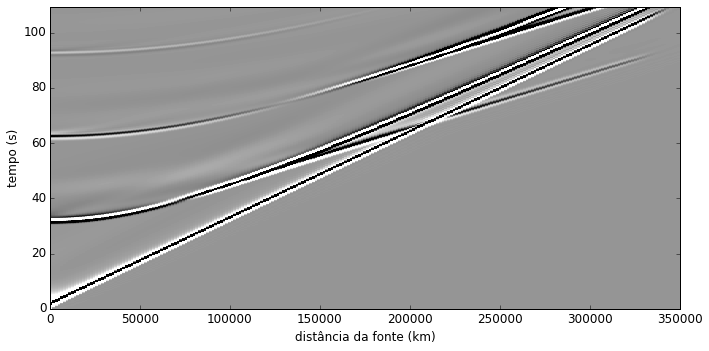

In [9]:
plota_dados(dados_moho, distancia, tempo)

As cores no gráfico acima representam a direção de oscilação na vertical. Escuro representa deslocamento para cima. Branco, para baixo. Cada tira vertical representa o sismograma de um sismômetro.

## Modelagem direta para uma camada

In [19]:
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
tmp = np.zeros_like(distancia)
plot_td, plot_tr = ax.plot(distancia, tmp, '-r', distancia, tmp, '-b', linewidth=2)
plota_dados(dados_moho, distancia, tempo, ax=ax)
def modelo_1_camada(h, v1, v2):
    td = distancia/v1
    critico = np.arcsin(v1/v2)
    tr = distancia/v2 + 2*h*np.cos(critico)/v1
    plot_td.set_ydata(td)
    plot_tr.set_ydata(tr)
    plt.draw()
    
widgets.interactive(modelo_1_camada,
                    h=widgets.FloatSliderWidget(min=1e3, max=100e3, step=1e3, value=20e3),
                    v1=widgets.FloatSliderWidget(min=500, max=10000, step=100, value=1000),
                    v2=widgets.FloatSliderWidget(min=500, max=10000, step=100, value=10000)) 

## Simulação de duas interfaces (bacia-embasamento e Moho)

In [ ]:
shape = (200, 800)
spacing = 500
extent = [0, shape[1]*spacing, shape[0]*spacing, 0]
densidade = np.ones(shape)*1800
velocidade = np.ones(shape)*2000
l = 10e3//spacing
densidade[l:,:] = 2700
velocidade[l:,:] = 3500
l = 50e3//spacing
densidade[l:,:] = 3300
velocidade[l:,:] = 5000

In [ ]:
sim2 = ElasticSH(velocidade, densidade, spacing=spacing, taper=0.003, padding=80)
sim2.add_point_source((0, 100), Ricker(5, 0.5, 1/0.5))
print(sim2.cachefile)

In [ ]:
sim2.run(3000)

In [ ]:
sim2.animate(every=30, embed=True, dpi=70, fps=7, cutoff=0.00005, cmap="Greys")

In [ ]:
dados_moho_bacia = sim2[:, 0, 100::5]

In [ ]:
plota_dados(dados_moho_bacia, distancia, tempo)

## Modelagem direta para duas camadas

In [ ]:
def modelo_1_camada(h1, h2, v1, v2, v3):
    # h2 deveria ser a espessura da segunda camada
    # O que eu estou modelando é a profuncidade da camada
    # Então a espessura é a profundidade menos a espessura da de cima
    h2 -= h1
    td = distancia/v1
    critico12 = np.arcsin(v1/v2)
    tr1 = distancia/v2 + 2*h1*np.cos(critico12)/v1
    critico23 = np.arcsin(v2/v3)
    tr2 = distancia/v3 + 2*h1*np.cos(critico12)/v1 + 2*h2*np.cos(critico23)/v2
    plt.figure(figsize=(10, 5))
    ax = plt.subplot(111)
    ax.plot(distancia, td, '-r', distancia, tr1, '-b', distancia, tr2, '-y', linewidth=2)
    plota_dados(dados_moho_bacia, distancia, tempo, ax=ax)
widgets.interactive(modelo_1_camada,
                    h1=widgets.FloatSliderWidget(min=1e3, max=100e3, step=1e3, value=1e3),
                    h2=widgets.FloatSliderWidget(min=1e3, max=100e3, step=1e3, value=20e3),
                    v1=widgets.FloatSliderWidget(min=500, max=10000, step=100, value=500),
                    v2=widgets.FloatSliderWidget(min=500, max=10000, step=100, value=5000),
                    v3=widgets.FloatSliderWidget(min=500, max=10000, step=100, value=10000)) 